In [1]:
from pandas import read_excel
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# 모델을 구성하기위한 객체
from tensorflow.keras.models import Sequential
# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense
# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 학습에 대한 콜백함수 처리용 패키지 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
# 회귀분석을 수행하는 통계 패키지 (머신러닝과는 연관 없음)
from statsmodels.formula.api import ols

In [2]:
df = read_excel('http://itpaper.co.kr/data/cars.xlsx', engine='openpyxl')
df.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


### 탐색적 데이터 분석
- 정규화 : 값이 클 수록 계산상의 오차가 커지기 때문에 모든 값들을 0~1 사이의 값으로 변환 하여 처리하는 기법
- 표준화 : 변수간의 단위가 클 경우 계산상이 오차가 커지기 때문에 모든 값들의 평균을 0으로 설정하고 표준편차가 1 이내가 되도록 값을 재조정

In [3]:
mms = MinMaxScaler()
normal_df = DataFrame(mms.fit_transform(df), index=df.index, columns=df.columns)
normal_df

,speed,dist
0,0.000000,0.000000
1,0.000000,0.067797
2,0.142857,0.016949
3,0.142857,0.169492
4,0.190476,0.118644
5,0.238095,0.067797
6,0.285714,0.135593
7,0.285714,0.203390
8,0.285714,0.271186
9,0.333333,0.127119


In [4]:
x_train, x_test, y_train, y_test = train_test_split(normal_df['speed'], normal_df['dist'], test_size = 0.33, random_state = 777)
print("훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d" % (len(x_train), len(x_test)))

훈련용 데이터셋 크기: 33, 검증용 데이터셋 크기: 17


### 학습하기
학습 도중 수행할 기능에 대한 옵션으로 콜백을 설정.<br>

콜백은 리스트 타입으로 사용하고자 하는 기능들을 객체생성 방식으로 나열.<br>

콜백 - 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링<br>

● `ModelCheckpoint`

- 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용
ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')

- filepath: 모델의 저장 경로를 지정
- monitor: 모니터링할 평가지표를 설정. 모델이 포함하고 있는 모든 지표를 사용할 수 있다.
      val_loss, var_mes, loss, mes
- verbose: 콜백의 수행 과정 노출 여부를 지정. 0: 아무런 표시 하지 않음(기본값) 1: 프로그래스바로 표시 2: 매 에폭마다 수행과정을 자세하게 출력함.
- save_best_only: True인 경우, 가장 성능이 뛰어난 모델만 저장. 그보다 좋지 않은 모델의 경우는 덮어쓰지 않는다.
- save_weights_only: 모델의 가중치만 저장
- mode: {'auto', 'min', 'max'} 중 하나를 사용. monitor에서 지정한 평가지표를 기준 으로 작동 평가지표가 val_acc인 경우 max를 선택 해야 함. val_loss인 경우 min을 선택해 해야 함. auto인 경우 평가지표의 이름을 통해 자동으로 유추<br>
● `EarlyStopping`

- 모델 학습 시에 지정된 기간 동안 모니터링하는 평가지표에서 성능 향상이 일어나지 않은 경우 학습을 중단
EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

- patience: 지정한 수만큼의 기간에서 평가지표의 향상이 일어나지 않을 경우 학습을 중단 (기간이라 함은 에폭을 의미) 예를 들어 patience=5일 때, 5에폭 동안 성능 향상이 일어나지 않으면 학습을 중단<br>
● `ReduceLROnPlateau`

- EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, min_lr=0)

- factor: 학습률 조정에 사용되는 값 (새로운 학습률 = factor * 기존 학습률)
- patience: 지정한 수만큼의 기간에서 성능 향상이 일어나지 않을 경우, 학습률을 조정
- min_lr: 학습률의 하한을 지정

In [5]:
# 데이터가 단순하고 개수가 적다면 과대적합이 발생할 확률이 높기 때문에 주의하면서 적절한 크기의 모델층을 쌓아야 한다.
model = Sequential()
# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(32, activation = 'relu', input_shape = (1, )))
# 하나의 값을 출력
# -> 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
# -> linear는 기본값이므로 생략 가능함.
model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [6]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=2),
    ModelCheckpoint(filepath = '{epoch:02d}-{val_loss:.5f}.h5', monitor = 'val_loss', verbose=2, save_best_only = True)
])
result.history.keys()

Epoch 1/500
2/2 [==============================] - 1s 177ms/step - loss: 0.1584 - mae: 0.3329 - val_loss: 0.0886 - val_mae: 0.2518

Epoch 00001: val_loss improved from inf to 0.08864, saving model to 01-0.08864.h5
Epoch 2/500
2/2 [==============================] - 0s 16ms/step - loss: 0.1443 - mae: 0.3142 - val_loss: 0.0796 - val_mae: 0.2356

Epoch 00002: val_loss improved from 0.08864 to 0.07962, saving model to 02-0.07962.h5
Epoch 3/500
2/2 [==============================] - 0s 21ms/step - loss: 0.1315 - mae: 0.2962 - val_loss: 0.0712 - val_mae: 0.2194

Epoch 00003: val_loss improved from 0.07962 to 0.07117, saving model to 03-0.07117.h5
Epoch 4/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1193 - mae: 0.2779 - val_loss: 0.0634 - val_mae: 0.2034

Epoch 00004: val_loss improved from 0.07117 to 0.06345, saving model to 04-0.06345.h5
Epoch 5/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1079 - mae: 0.2601 - val_loss: 0.0566 - val_mae: 0.1882

Epoc

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

In [7]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.158385,0.332915,0.088635,0.251850,0.0010
2,0.144286,0.314227,0.079621,0.235640,0.0010
3,0.131531,0.296168,0.071166,0.219420,0.0010
4,0.119269,0.277941,0.063445,0.203450,0.0010
5,0.107944,0.260100,0.056612,0.188230,0.0010
6,0.097701,0.243725,0.050459,0.174978,0.0010
7,0.088583,0.227867,0.045051,0.162290,0.0010
8,0.080017,0.212665,0.040156,0.150665,0.0010
9,0.072678,0.198686,0.035814,0.140481,0.0010


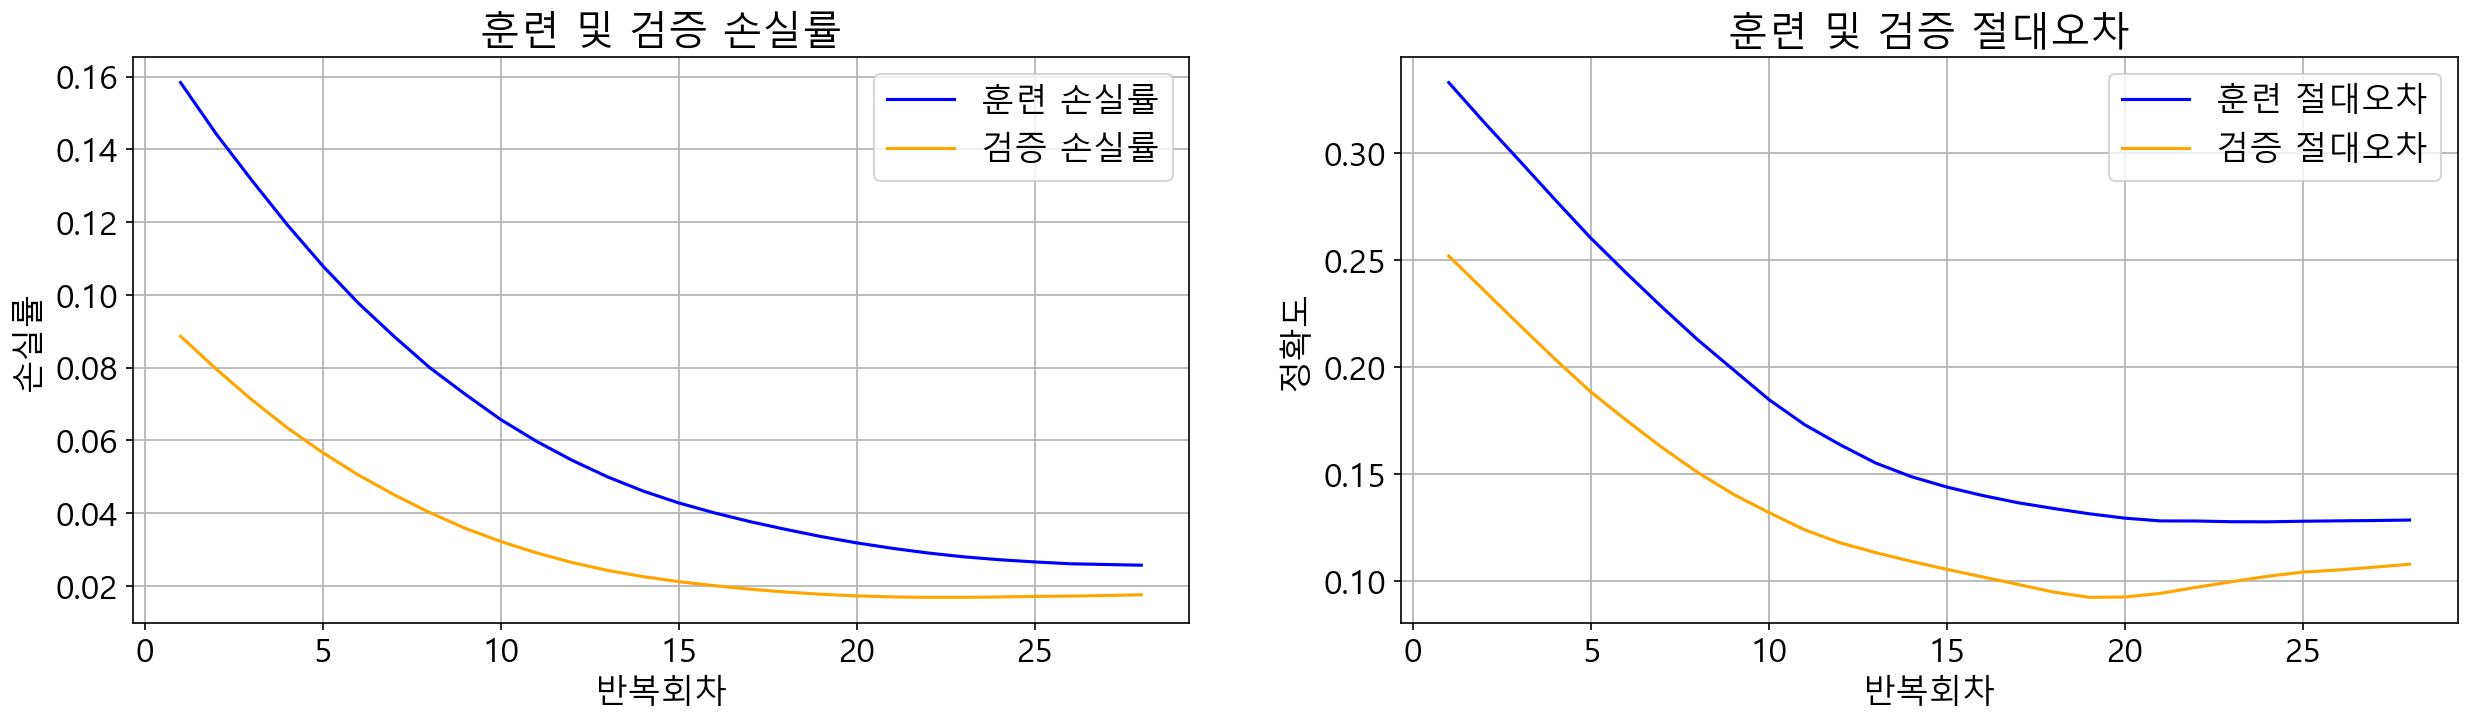

In [8]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sns.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [9]:
evaluate = model.evaluate(x_test, y_test)
print("최종 손실률: %f, 최종 절대오차: %f" % (evaluate[0], evaluate[1]))

1/1 [==============================] - 0s 15ms/step - loss: 0.0175 - mae: 0.1078
최종 손실률: 0.017533, 최종 절대오차: 0.107793


In [10]:
# 검증 데이터를 활용하여 dist 예측하기
test_predictions = model.predict(x_test)
test_predictions

array([[0.49907088],
       [0.3240476 ],
       [0.30609018],
       [0.2873862 ],
       [0.429083  ],
       [0.34159815],
       [0.34159815],
       [0.41158602],
       [0.30609018],
       [0.429083  ],
       [0.34159815],
       [0.44657993],
       [0.203068  ],
       [0.3240476 ],
       [0.11493245],
       [0.2678496 ],
       [0.3240476 ]], dtype=float32)

In [11]:
# 2차 배열의 원소들을 1차 배열로 재배치
test_pred_flatten = test_predictions.flatten()
test_pred_flatten

array([0.49907088, 0.3240476 , 0.30609018, 0.2873862 , 0.429083  ,
       0.34159815, 0.34159815, 0.41158602, 0.30609018, 0.429083  ,
       0.34159815, 0.44657993, 0.203068  , 0.3240476 , 0.11493245,
       0.2678496 , 0.3240476 ], dtype=float32)

In [12]:
result_df = DataFrame({'검증데이터': x_test, '실제값': y_test, '예측값': test_pred_flatten})
result_df['예측오차'] = result_df['실제값']-result_df['예측값']
result_df

,검증데이터,실제값,예측값,예측오차
44,0.904762,0.440678,0.499071,-0.058393
17,0.428571,0.271186,0.324048,-0.052861
11,0.380952,0.101695,0.306090,-0.204395
9,0.333333,0.127119,0.287386,-0.160268
36,0.714286,0.372881,0.429083,-0.056202
21,0.476190,0.491525,0.341598,0.149927
22,0.476190,0.661017,0.341598,0.319419
31,0.666667,0.338983,0.411586,-0.072603
12,0.380952,0.152542,0.306090,-0.153548
37,0.714286,0.559322,0.429083,0.130239


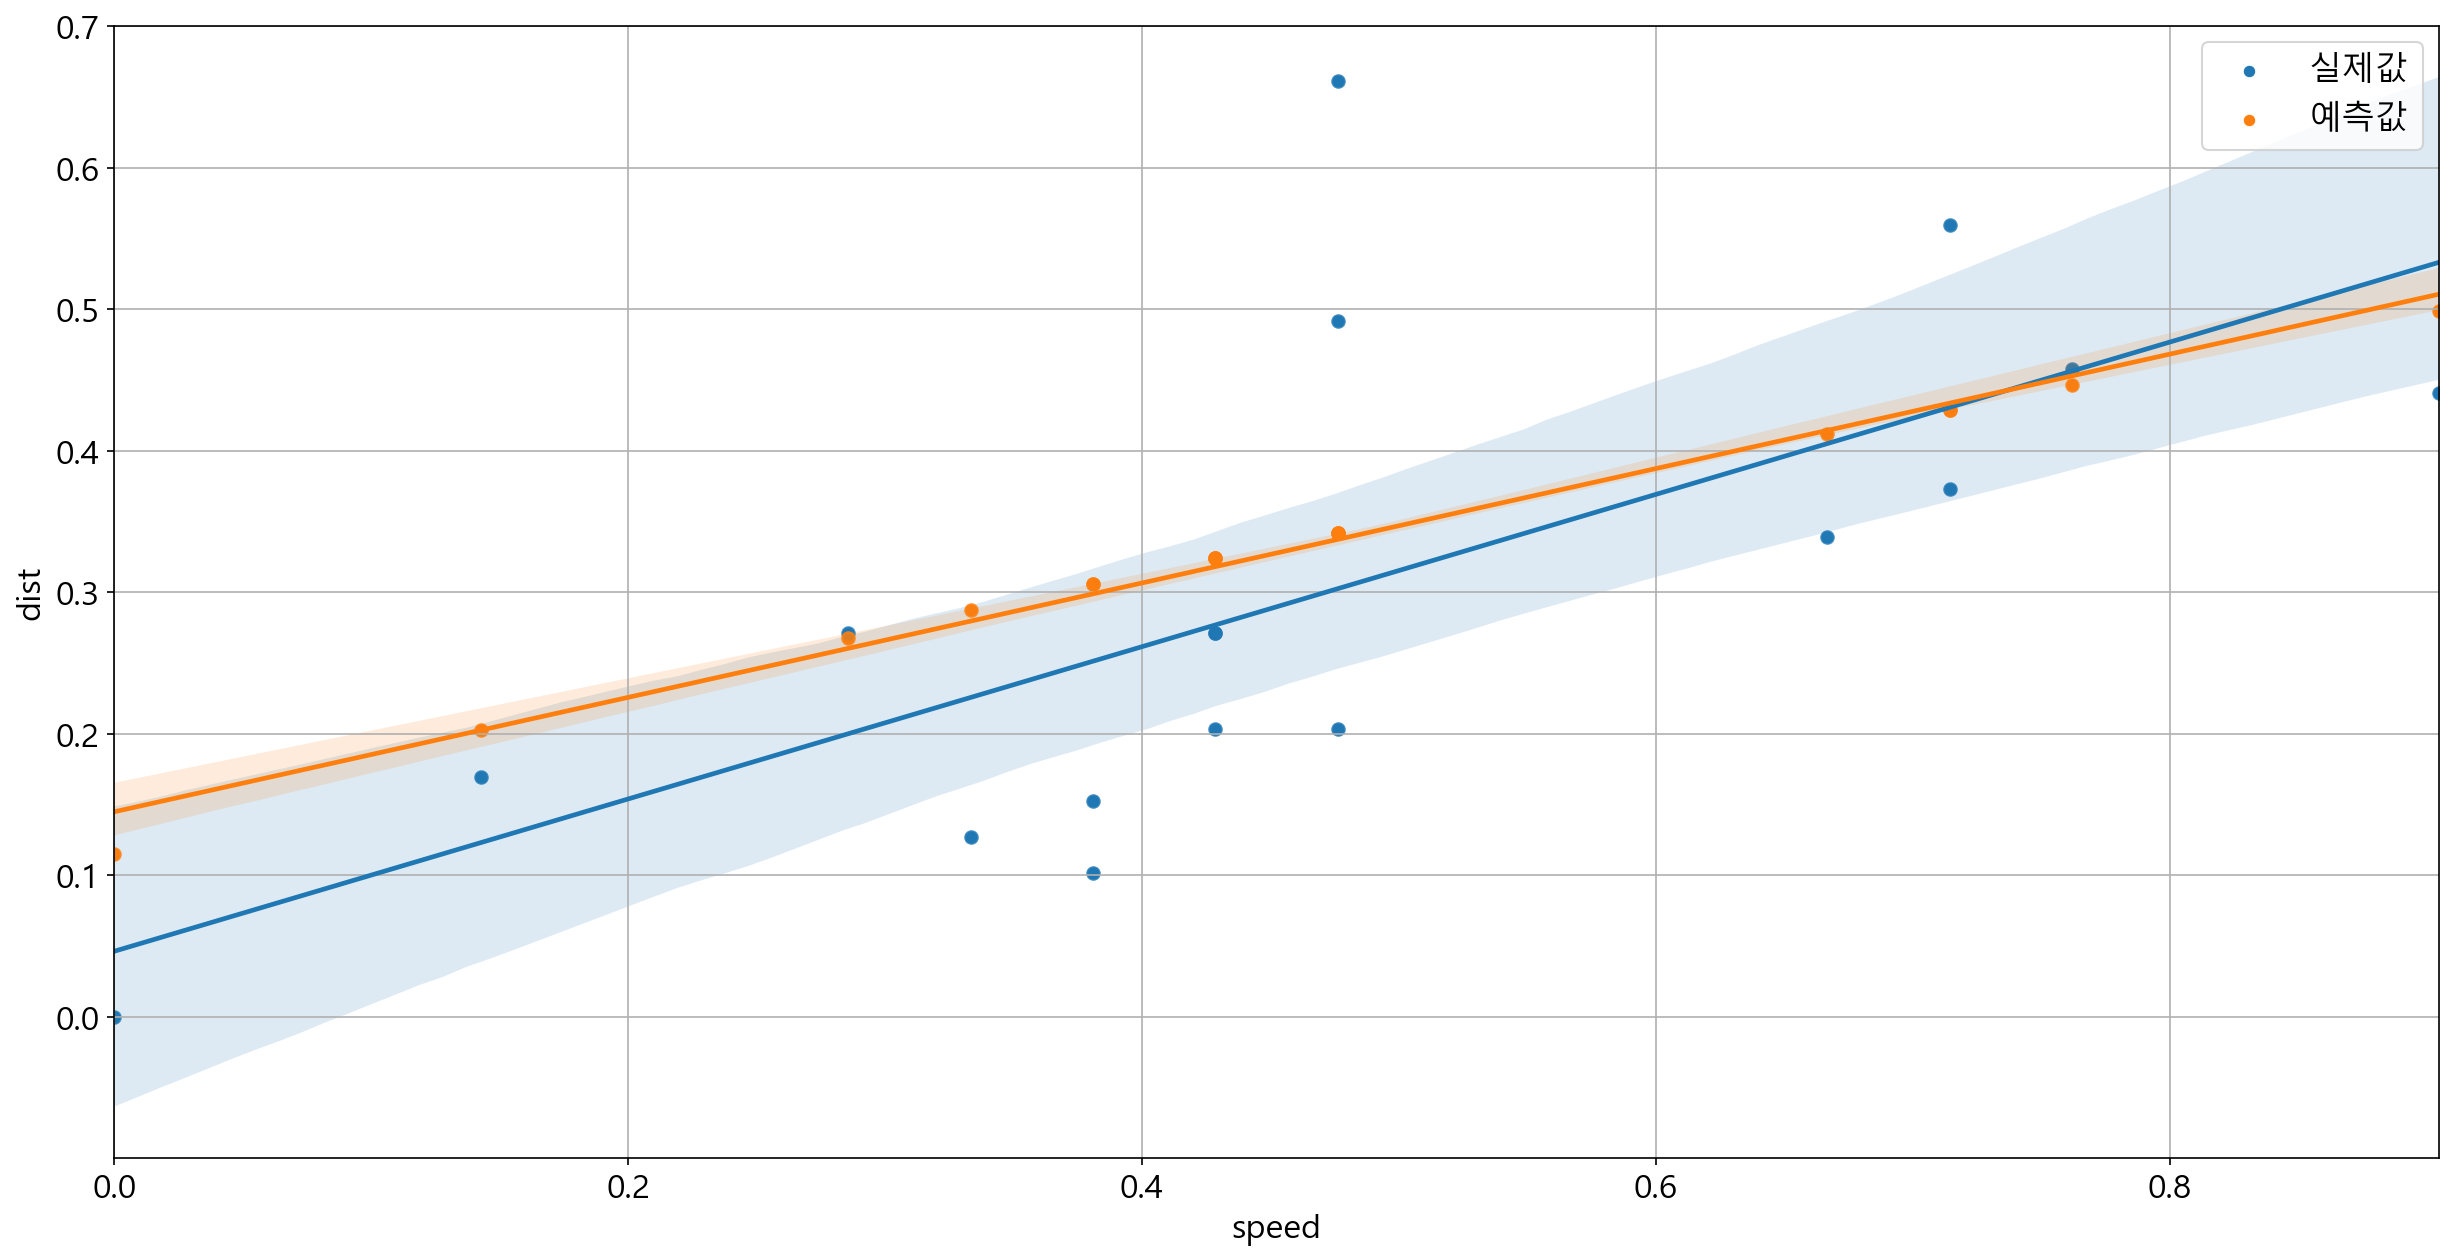

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=150)
sns.scatterplot(x='검증데이터', y='실제값', data=result_df, label='실제값')
sns.scatterplot(x='검증데이터', y='예측값', data=result_df, label='예측값')
sns.regplot(x='검증데이터', y='실제값', data=result_df)
sns.regplot(x='검증데이터', y='예측값', data=result_df)
ax.set_xlabel('speed')
ax.set_ylabel('dist')
ax.legend()
ax.grid()

plt.show()
plt.close()

In [14]:
ols_model = ols('dist ~ speed', data=normal_df)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           1.49e-12
Time:                        14:21:38   Log-Likelihood:                 31.956
No. Observations:                  50   AIC:                            -59.91
Df Residuals:                      48   BIC:                            -56.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0326      0.044     -0.739      0.464      -0.121       0.056
speed          0.6998      0.074      9.464      0.000       0.551       0.849
==============================================================================
Omnibus:                        8.975   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.189
Skew:                           0.885   Prob(JB):                       0.0167
Kurtosis:                       3.893   Cond. No.                         5.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
fit.fittedvalues

0    -0.032623
1    -0.032623
2     0.067354
3     0.067354
4     0.100679
5     0.134005
6     0.167330
7     0.167330
8     0.167330
9     0.200656
10    0.200656
11    0.233981
12    0.233981
13    0.233981
14    0.233981
15    0.267307
16    0.267307
17    0.267307
18    0.267307
19    0.300632
20    0.300632
21    0.300632
22    0.300632
23    0.333958
24    0.333958
25    0.333958
26    0.367283
27    0.367283
28    0.400609
29    0.400609
30    0.400609
31    0.433934
32    0.433934
33    0.433934
34    0.433934
35    0.467260
36    0.467260
37    0.467260
38    0.500585
39    0.500585
40    0.500585
41    0.500585
42    0.500585
43    0.567236
44    0.600562
45    0.633887
46    0.633887
47    0.633887
48    0.633887
49    0.667213
dtype: float64

In [16]:
result_df['분석값'] = fit.fittedvalues
result_df['분석오차'] = result_df['실제값']-result_df['분석값']
result_df


,검증데이터,실제값,예측값,예측오차,분석값,분석오차
44,0.904762,0.440678,0.499071,-0.058393,0.600562,-0.159884
17,0.428571,0.271186,0.324048,-0.052861,0.267307,0.003880
11,0.380952,0.101695,0.306090,-0.204395,0.233981,-0.132287
9,0.333333,0.127119,0.287386,-0.160268,0.200656,-0.073537
36,0.714286,0.372881,0.429083,-0.056202,0.467260,-0.094379
21,0.476190,0.491525,0.341598,0.149927,0.300632,0.190893
22,0.476190,0.661017,0.341598,0.319419,0.300632,0.360385
31,0.666667,0.338983,0.411586,-0.072603,0.433934,-0.094951
12,0.380952,0.152542,0.306090,-0.153548,0.233981,-0.081439
37,0.714286,0.559322,0.429083,0.130239,0.467260,0.092062


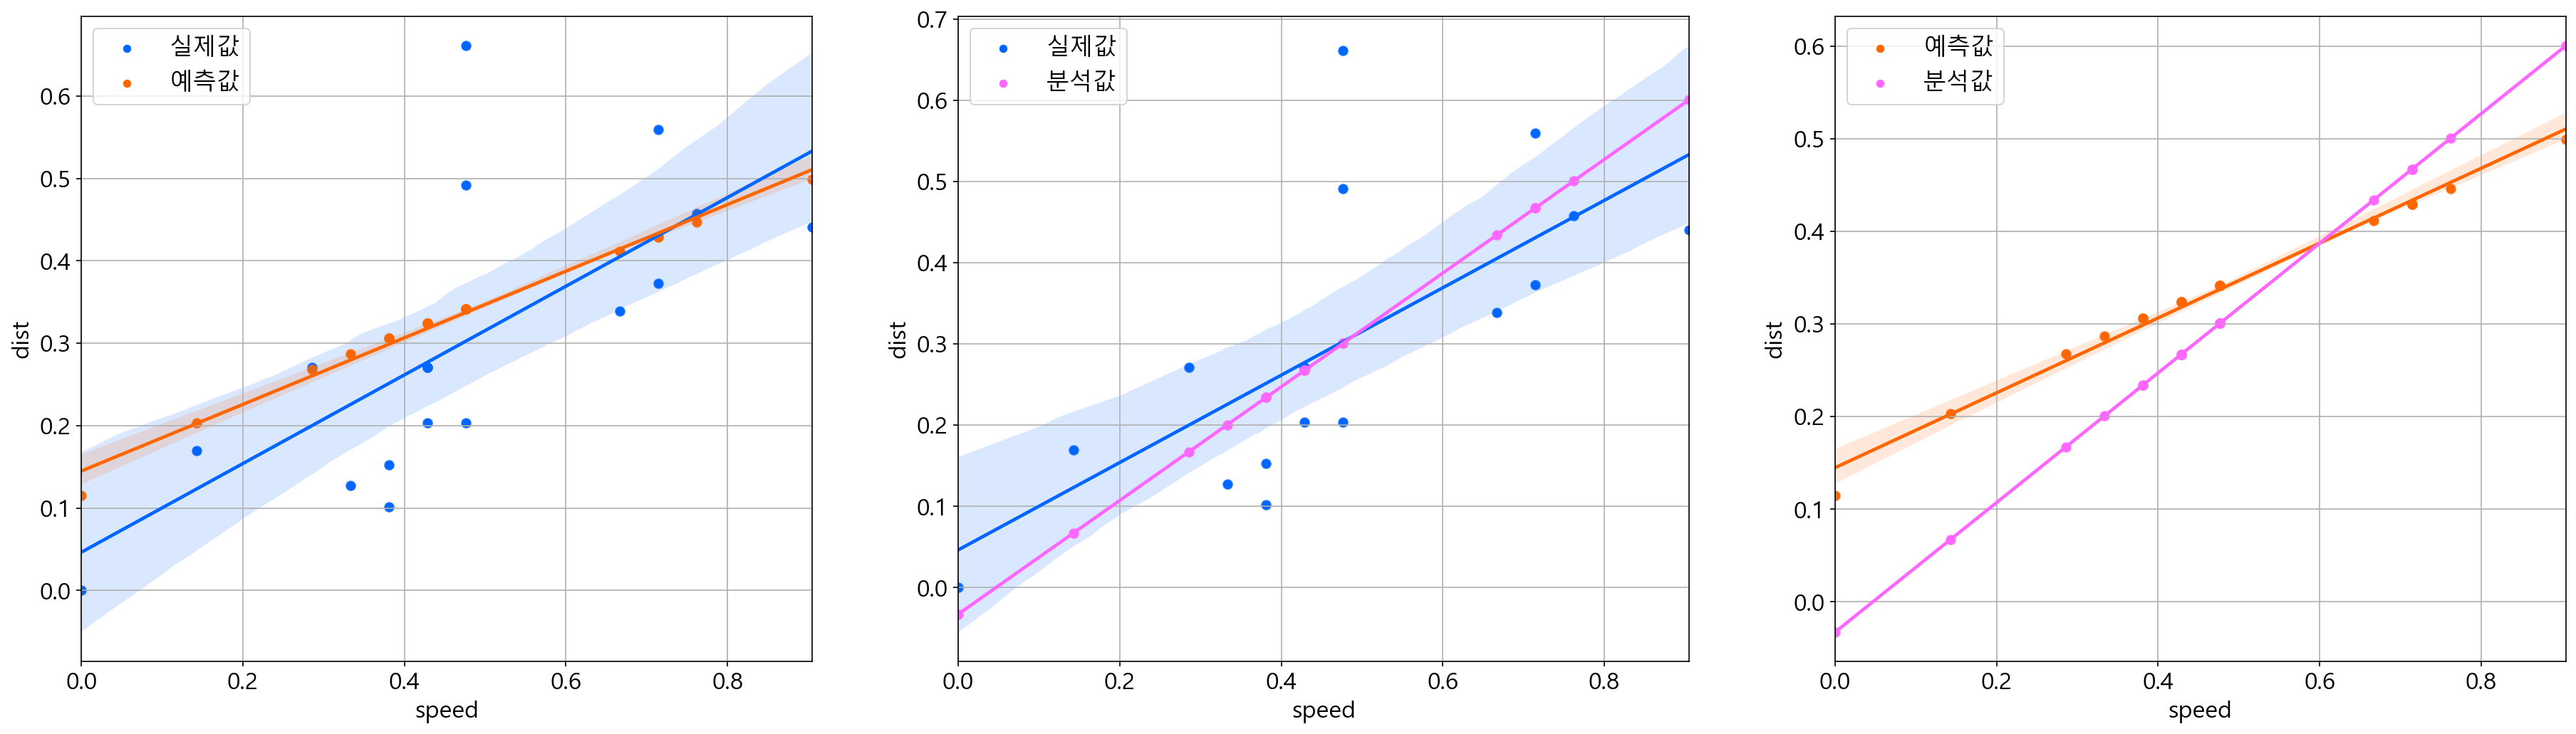

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8), dpi=150)
sns.scatterplot(x='검증데이터', y='실제값', data=result_df, color='#0066ff', label='실제값', ax=ax1)
sns.scatterplot(x='검증데이터', y='예측값', data=result_df, label='예측값', color='#ff6600', ax=ax1)
sns.regplot(x='검증데이터', y='실제값', data=result_df, color='#0066ff', ax=ax1)
sns.regplot(x='검증데이터', y='예측값', data=result_df, color='#ff6600', ax=ax1)

sns.scatterplot(x='검증데이터', y='실제값', data=result_df, color='#0066ff', label='실제값', ax=ax2)
sns.scatterplot(x='검증데이터', y='분석값', data=result_df, label='분석값', color='#ff66ff', ax=ax2)
sns.regplot(x='검증데이터', y='실제값', data=result_df, color='#0066ff', ax=ax2)
sns.regplot(x='검증데이터', y='분석값', data=result_df, color='#ff66ff',ax=ax2)

sns.scatterplot(x='검증데이터', y='예측값', data=result_df, label='예측값', color='#ff6600', ax=ax3)
sns.scatterplot(x='검증데이터', y='분석값', data=result_df, label='분석값', color='#ff66ff',ax=ax3)
sns.regplot(x='검증데이터', y='예측값', data=result_df, color='#ff6600', ax=ax3)
sns.regplot(x='검증데이터', y='분석값', data=result_df, color='#ff66ff',ax=ax3)

ax1.set_xlabel('speed')
ax1.set_ylabel('dist')
ax1.legend(loc='upper left')
ax1.grid()

ax2.set_xlabel('speed')
ax2.set_ylabel('dist')
ax2.legend(loc='upper left')
ax2.grid()

ax3.set_xlabel('speed')
ax3.set_ylabel('dist')
ax3.legend(loc='upper left')
ax3.grid()

plt.show()
plt.close()

In [18]:
result_df['예측오차'].mean()

-0.03556096023422177

In [19]:
result_df['분석오차'].mean()

0.0028894047783655213